# Курс по машинному обучению,   ВМК МГУ
## SVM

### Важно! О формате сдачи

* **Практически все выделенные задания из ноутбука оцениваются по системе <font color='red'>кросс-рецензирования</font>. Задания, в котором надо реализовать свой код и послать в систему, выделены здесь и в pdf отдельно**
* **В этом задании есть новый тип задания -- ML-решение**
* **При решении ноутбука используйте данный шаблон. Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно можно**
* **Везде, где в формулровке задания есть какой-либо вопрос (или просьба вывода), необходимо прописать ответ в ячейку (код или markdown).**
* **Наличие кода решения обязательно. Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.**

### Важно!

**Перед тем, как сдать ноутбук на кросс-рецензирование, мы рекомендуем перезапустить ядро и выполнить весь ноутбук (cell -> run all). При правильном выполнении весь процесс работы ноутбука не должен занять больше 20 минут**

__В этом задании вы..:__

- Изучите работу модели SVM
- Поймете, как с её помощью можно строить нелинейные разделяющие поверхности
- Потренируетесь в подборе оптимальных параметров на обучающей выборке для достижения наилучшего качества на закрытой выборке (ML-решение)
- Узнаете про метод, который позволяет понижать число признаков и изучите его особенности на практике
- Научитесь корректировать выход модели SVM-классификатора, чтобы уметь получать вероятности

**А также..**

Если в ячейке написана фраза "Вывод", то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если в ячейке написано "Your code here", то ожидается ответ в виде кода (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если есть и ячейка с фразой "Вывод", и ячейка с фразой "Your code here", то в ответе ожидается и код, и текст)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from copy import copy

Если Вы дальтоник, то можете воспользоваться готовой colormap из matplotlib (или найти свою):
```
plt.style.use('tableau-colorblind10')
```

In [2]:
from matplotlib.colors import ListedColormap

from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score
from sklearn.datasets import make_blobs, make_circles, make_moons

In [3]:
def make_moons_cls(size=1000, d=2):
    X, y = make_moons(n_samples=size, noise=0.15)
    if d > 2:
        X = np.concatenate((X, np.random.normal(size=(size, d-2))), axis=1)
    return X, y

def make_circles_cls():
    X, y = make_circles()
    
def generate_data_with_imb_classes(size1=100, size2=10):
    X = np.r_[(
        np.random.normal(size=(size1, 2)),
        np.random.normal(loc=2.0, size=(size2, 2))
    )]
    
    y = np.ones(len(X))
    y[-size2:] = 0
    return X, y

In [4]:
def plot_separating_surface(X, y, cls, view_support=False, title=''):
    x_min = min(X[:, 0]) - 0.1
    x_max = max(X[:, 0]) + 0.1
    y_min = min(X[:, 1]) - 0.1
    y_max = max(X[:, 1]) + 0.1
    h = 0.005
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
    Z = cls.predict(np.c_[xx.ravel(), yy.ravel()])

    plt.figure(figsize=(10, 10))
    if title:
        plt.title(title)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', s=40, cmap=cm_bright)
    if view_support:
        plt.scatter(X[cls.support_, 0], X[cls.support_, 1], 
                    c=y[cls.support_], edgecolors='k', s=150, cmap=cm_bright)
    Z = Z.reshape(xx.shape)
    plt.xticks(())
    plt.yticks(())
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.3)
    plt.show()

# 1. Разделяющая поверхность (1 балл)

В ячейке ниже генерируется выборка, состоящая из объектов двух классов. Каждый объект представлен двумя координатами, так что объекты этой выборки можно отобразить на плоскости, используя функцию scatter из библиотеки matplotlib.
    
В этом задании вам надо будет обучить линейную разделяющую поверхность с помощью $\mbox{sklearn.svm.SVC(kernel='linear')}$, а также нелинейную c rbf-ядром с помощью $\mbox{sklearn.svm.SVC(kernel='rbf')}$. Остальные параметры методов можете оставить дефолтными. Делить выборку на обучение и валидацию сейчас не требуется, так как нас будет пока интересовать только форма разделяющей кривой.

In [5]:
X, y = make_moons_cls()
linear_svc = SVC(kernel='linear')
nonlinear_svc = SVC(kernel='rbf')

Визуализируем выборку

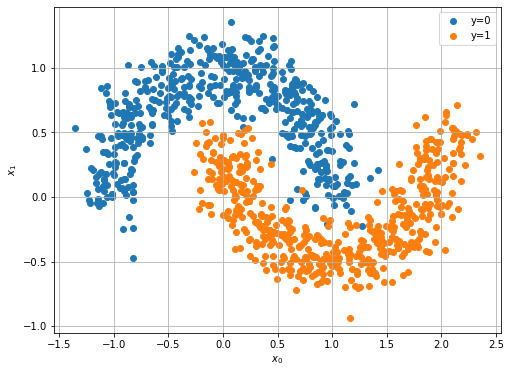

In [6]:
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], label='y=0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], label='y=1')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.legend()
plt.grid()

Обучите модели и визуализируйте разделяющую поверхность для обеих моделей с помощью функции plot_separating_surface(). Посчитайте точность (accuracy) на обучающей выборке для каждой из моделей.

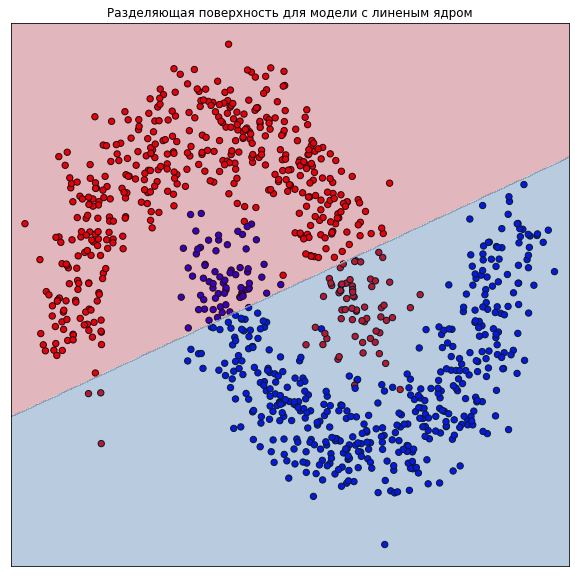

Точность модели с линейным ядром на обучении: 0.865


In [7]:
linear_svc.fit(X, y)
plot_separating_surface(X, y, linear_svc, title='Разделяющая поверхность для модели с линеным ядром')
print("Точность модели с линейным ядром на обучении:", accuracy_score(y, linear_svc.predict(X)))

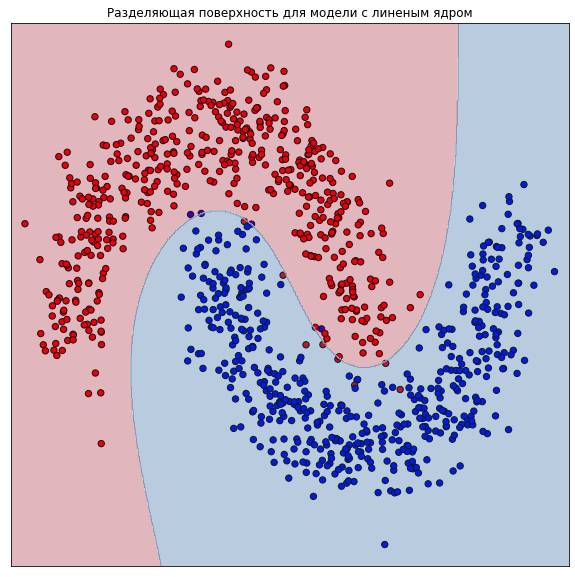

Точность модели с RBF ядром на обучении: 0.988


In [8]:
nonlinear_svc.fit(X, y)
plot_separating_surface(X, y, nonlinear_svc, title='Разделяющая поверхность для модели с линеным ядром')
print("Точность модели с RBF ядром на обучении:", accuracy_score(y, nonlinear_svc.predict(X)))

Сделайте вывод
о получившихся результатах. Какая из моделей лучше подходит для данной выборки и почему? 

**Вывод:** точность модели с RBF ядром (0.989) значительно превосходит точность модели с линейным ядром (0.882). Очевидно, что модель с RBF ядром подходит лучше, т.к. выборка совсем далека от линейно разделимой.

# 2. Опорные объекты (2 балла)

Продолжаем работать с выборкой и моделями из первой части. Для линейной и rbf-моделей рассмотрим 
    опорные объекты, полученные после обучения. Визуализировать их можно, используя функуцию plot_separating_surface с параметром vis_support=True. Достать опорные объекты из обученной модели можно с помощью поля model.support_.

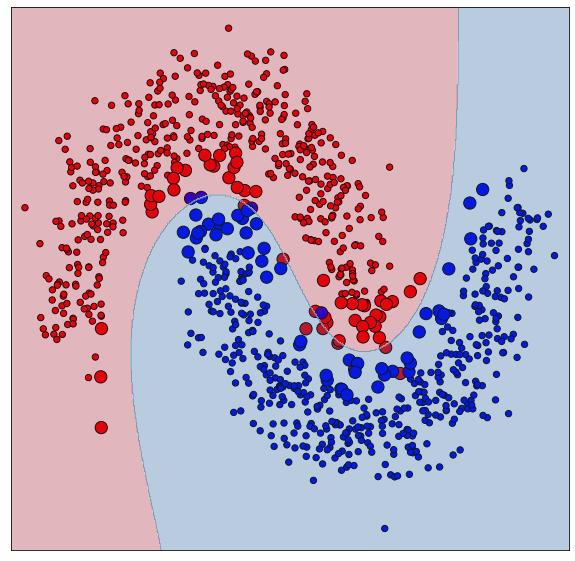

In [9]:
plot_separating_surface(X, y, nonlinear_svc, view_support=True)

**Пункт 1**
Обучите новые две модели $\mbox{SVC(kernel='rbf')}$, используя только опорные объекты построенные с помощью соответственно линейной (linear_svc) и нелинейной (nonlinear_svc) моделей из первой части.

In [10]:
svc_on_linear_support = SVC(kernel='rbf')
svc_on_rbf_support = SVC(kernel='rbf')

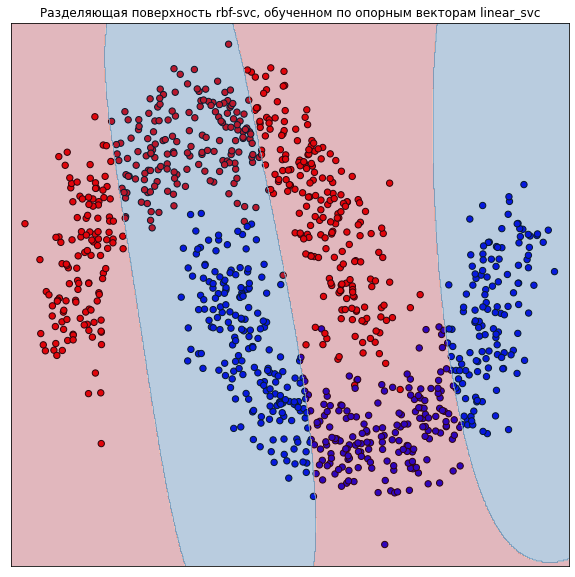

Точность rbf-svc, обученном по опорным векторам linear_svc, на обучении: 0.654


In [11]:
svc_on_linear_support.fit(X[linear_svc.support_], y[linear_svc.support_])
plot_separating_surface(X, y, svc_on_linear_support, title='Разделяющая поверхность rbf-svc, обученном по опорным векторам linear_svc')
print("Точность rbf-svc, обученном по опорным векторам linear_svc, на обучении:", accuracy_score(y, svc_on_linear_support.predict(X)))

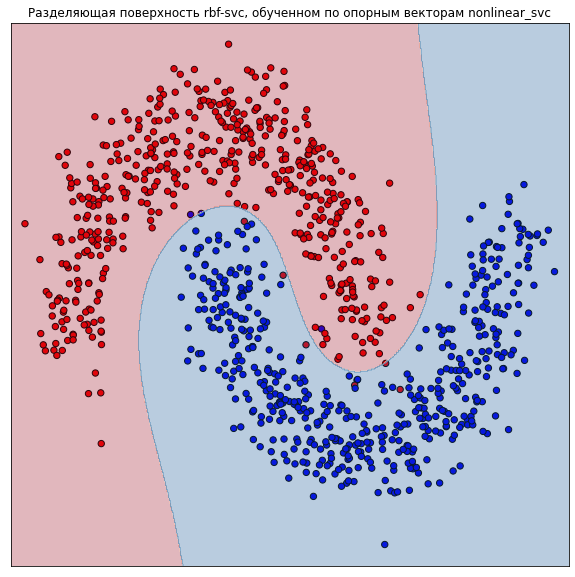

Точность rbf-svc, обученном по опорным векторам nonlinear_svc, на обучении: 0.992


In [12]:
svc_on_rbf_support.fit(X[nonlinear_svc.support_], y[nonlinear_svc.support_])
plot_separating_surface(X, y, svc_on_rbf_support, title='Разделяющая поверхность rbf-svc, обученном по опорным векторам nonlinear_svc')
print("Точность rbf-svc, обученном по опорным векторам nonlinear_svc, на обучении:", accuracy_score(y, svc_on_rbf_support.predict(X)))

Сравните полученные разделяющие поверхности с нелинейной моделью (nonlinear_svc) из первой части. Какая из поверхностей больше похожа на нелинейнную модель из первой части и почему, опишите в выводе. 

**Вывод:** поверхность, полученная в результате обучения svc на опорных векторах linear_svc, совершенно не похожа на поверхность для nonlinear_svc, а поверхность, полученная в результате обучения svc на опорных векторах nonlinear_svc, визуально почти совпадает с поверхностью для nonlinear_svc. <br>
Происходит это по тому, что опорные вектора для модели linear_svc являются опорными только в пространстве с линейным скалярным произведением, а в пространстве с RBF ядром они таковыми не являются, а значит и решение получается совершнно другое.

**Пункт 2** Обучите модель $\mbox{SVC(kernel='rbf')}$, используя все объекты кроме тех, что являлись опорными для нелинейной модели из первой части (nonlinear_svc) и сравните эту модель вместе с svc_on_rbf_support с нелинейной моделью из первой части (nonlinear_svc). Визуализируйте разделяющие поверхности обеих моделей.

In [13]:
svc_all_without_rbf_support = SVC(kernel='rbf')

In [14]:
X_without_rbf_support = np.delete(X, nonlinear_svc.support_, axis=0)
y_without_rbf_support = np.delete(y, nonlinear_svc.support_, axis=0)
svc_all_without_rbf_support.fit(X_without_rbf_support, y_without_rbf_support)

SVC()

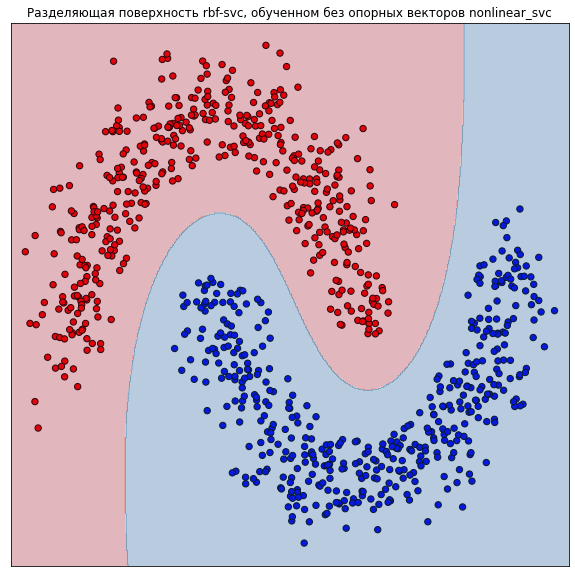

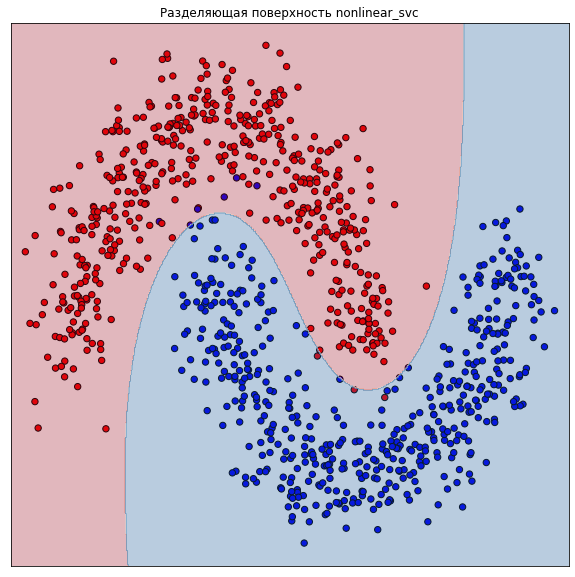

In [15]:
plot_separating_surface(X_without_rbf_support, y_without_rbf_support, nonlinear_svc, title='Разделяющая поверхность rbf-svc, обученном без опорных векторов nonlinear_svc')
plot_separating_surface(X, y, nonlinear_svc, title='Разделяющая поверхность nonlinear_svc')

In [16]:
print("Точность rbf-svc, обученном без опорных векторов nonlinear_svc, на обучении:", 
      accuracy_score(y_without_rbf_support, svc_all_without_rbf_support.predict(X_without_rbf_support)))
print("Точность nonlinear_svc на обучении:", accuracy_score(y, nonlinear_svc.predict(X)))

Точность rbf-svc, обученном без опорных векторов nonlinear_svc, на обучении: 1.0
Точность nonlinear_svc на обучении: 0.991


Сильно ли полученные поверхности отличаются от той, что была получена в первой части? Что произошло с пограничными объектами? Объясните полученные результаты.

**Вывод:** визуально разделяющие поверхности почти не отличаются. Также можем заметить, что модель, обученная без опорных векторов, имеет точность 1.0, т.е. не совершает ошибок. Дело в том, что в качестве опорных векторов в SVM выступают объекты, находящиеся близко к границе, а также объекты-выбросы (с отрицательным margin, т.е. неправильно классифицирующиеся). После того, как эти объекты были удалены, обучающая выборка стала линейно разделимой в некотором пространстве с скалярным произведением в виде RBF ядра.

# 3. Форма разделяющей поверхности для несбалансированных классов (3 балла)

Формы разделяющих поверхностей могут быть вариативными для нелинейного случая. Один из способов влиять на форму поверхности -- это веса классов, которые задаются через параметр class_weight в sklearn.svm.SVC. Особенно это может быть полезно в задачах, где известно, что распределение классов в обучающей выборке отличается от реального. Такое свойственно медицинским данным, где в обучающих данных часто наблюдается перекос в сторону больных, так как именно их данные чаще собираются.
    
В данном задании вам будет дана выборка с несбалансированными данными. Кроме того, дана вторая выборка,
в которой классы имеют то же распределение, но классы имеют другое соотношение.  Вам нужно построить различные rbf-модели, меняя параметры весов классов и визуализировать разделяющие поверхности. Попробуйте улучшить 
качество на второй выборке (X_distr2, y_distr2), обучаясь только на первой (X_distr1, y_distr1) меняя параметры весов классов относительно дефолтных: class_weight={1: 1.0, 0: 1.0}.

In [17]:
X_distr1, y_distr1 = generate_data_with_imb_classes(100, 10)
X_distr2, y_distr2 = generate_data_with_imb_classes(10, 100)

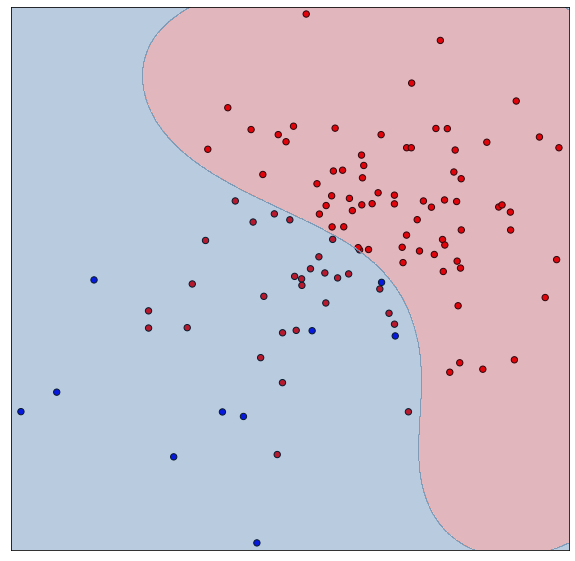

In [18]:
# Модель с дефолтными параметрами, которую Вам предстоит улучшить
base_model = SVC()
base_model.fit(X_distr1, y_distr1)
plot_separating_surface(X_distr2, y_distr2, base_model)

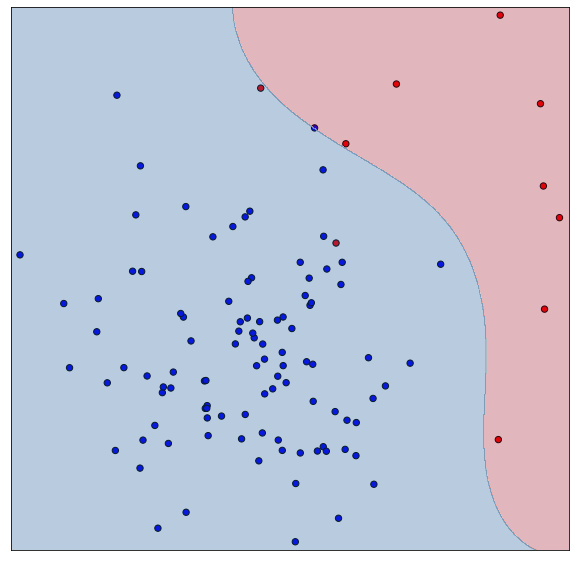

In [19]:
plot_separating_surface(X_distr1, y_distr1, base_model)

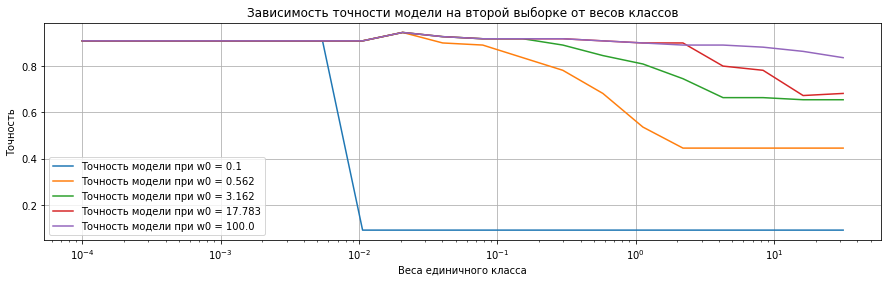

In [20]:
# массив весов единичного класса
w1_range = np.logspace(-4, 1.5, 20)

# массив весов нулевого класса
w0_range = np.logspace(-1, 2, 5)

# список соответствующих точностей на второй выборке
accuracy_list = []

for w0 in w0_range:
    accuracy_list.append([])
    for w1 in w1_range:
        model = SVC(kernel='rbf', class_weight = {1: w1, 0: w0}).fit(X_distr1, y_distr1)
        accuracy_list[-1].append(accuracy_score(y_distr2, model.predict(X_distr2)))
    
plt.figure(figsize=(15, 4))

for i, w0 in enumerate(w0_range):
    plt.plot(w1_range, accuracy_list[i], 
             label = 'Точность модели при w0 = ' + str(round(w0, 3)))    
plt.title('Зависимость точности модели на второй выборке от весов классов')
plt.xlabel('Веса единичного класса')
plt.ylabel('Точность')
plt.xscale("log")
plt.legend()
plt.grid()
plt.show()

In [21]:
print("Максимальная точность: ", np.max(accuracy_list[2]))
print("w0: ", w0_range[2])
print("w1: ", w1_range[np.argmax(accuracy_list[2])])

Максимальная точность:  0.9454545454545454
w0:  3.1622776601683795
w1:  0.0206913808111479


Построили графики зависимости точности модели от веса $w_1$ единичного класса при весах $w_0$ нулевого класса из $np.logspace(-1, 2, 5)$. Лучшую точность, как видно из графиков, показывает модель с паараметрами $w_0 = 3.16$, $w_1 = 0.078$
<br>
Построим разделяющие поверхности для нескольких значений параметра $w_1$ при фиксированном $w_0 = 0.316$:

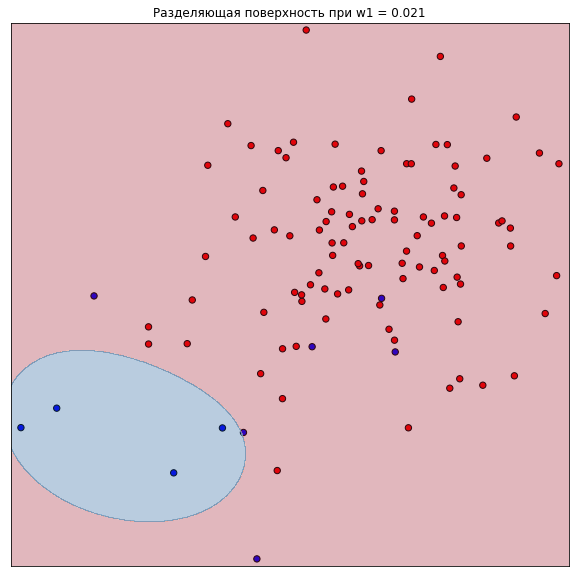

w0 = 3.16, w1 = 0.02
accuracy: 0.945


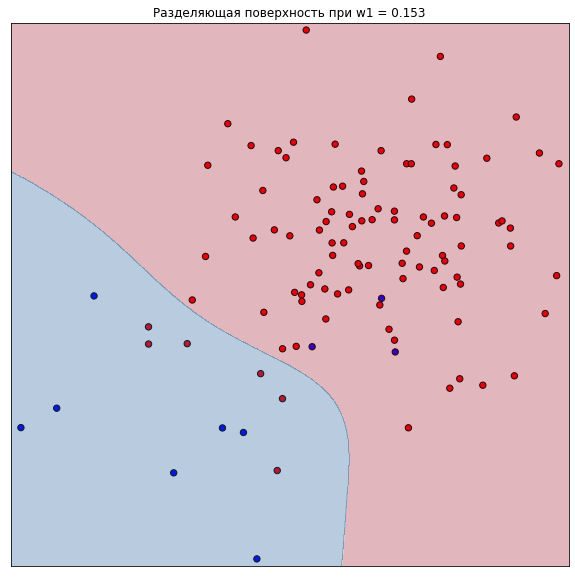

w0 = 3.16, w1 = 0.15
accuracy: 0.918


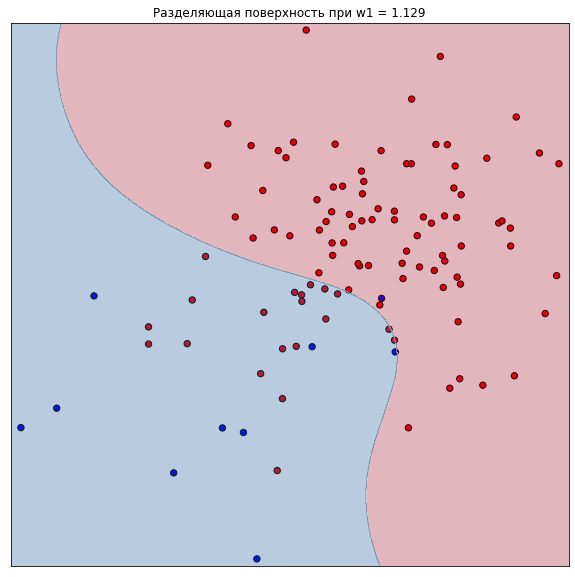

w0 = 3.16, w1 = 1.13
accuracy: 0.809


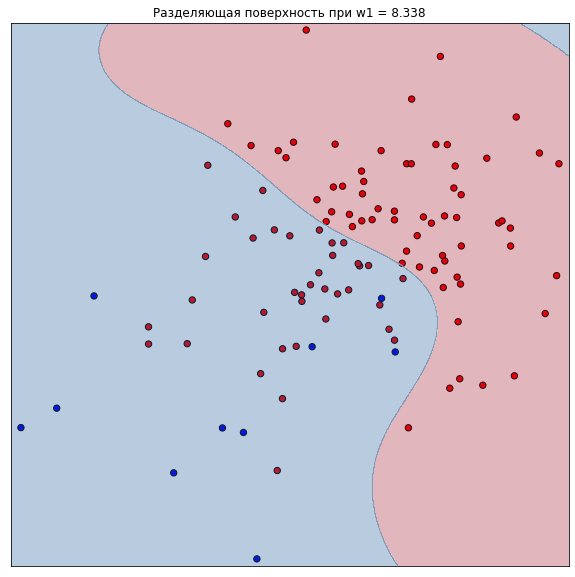

w0 = 3.16, w1 = 8.34
accuracy: 0.664


In [22]:
for i in range(np.argmax(accuracy_list[2]), len(accuracy_list[2]), 3):
    model = SVC(kernel='rbf', class_weight = {1: w1_range[i], 0: w0_range[2]}).fit(X_distr1, y_distr1)
    plot_separating_surface(X_distr2, y_distr2, model, title='Разделяющая поверхность при w1 = ' + str(round(w1_range[i], 3)))
    print(f"w0 = {round(w0_range[2], 2)}, w1 = {round(w1_range[i], 2)}")
    print(f"accuracy: {round(accuracy_score(y_distr2, model.predict(X_distr2)), 3)}")

# 4. Обучите лучшую SVM модель (контест, 20 баллов)

Возможность строить нелинейные поверхности может сильно улучшить качество, но и несет риск переобучения. 
    В этом задании предстоит обучить лучшую svm модель и получить хорошее качество на тесте в системе тестирования. Для контроля переобучения рекомендуется пользоваться кросс-валидацией. Для улучшения качества рекомендуется подбирать

1. параметр регуляризации C;
2. тип разделяющей кривой linear/rbf/poly;
3. степень в случае разделяющей кривой poly.

Также не забывайте, что при решении задач машинного обучения полезно смотреть в данные :) 

**Данные:** Все csv-таблицы с данными вы можете взять из публичного теста, который есть в проверяющей системе. Для этого распакуйте архив с публичными тестами и положите файлы в рабочей директории (рядом с ноутбуком)

**Метрика качества:** accuracy_score

**Используемая модель:** SVC

In [84]:
X_train = pd.read_csv('train_features.csv')
y_train = pd.read_csv('train_target.csv')
X_test = pd.read_csv('test_features.csv') # Только для оценивания качества на паблике!
y_test = pd.read_csv('test_target.csv') # Только для оценивания качества на паблике!

In [85]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((800, 5), (800, 1), (10, 5), (10, 1))

In [86]:
np.unique(y_train, return_counts=True)

(array([0., 1.]), array([441, 359], dtype=int64))

In [87]:
from sklearn.model_selection import cross_val_score

In [88]:
def check_model(model, X, y, cv=5, n_jobs=2):
    if type(X) == pd.DataFrame:
        X = np.array(X)
    return cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=n_jobs)

In [89]:
c_list = np.logspace(-5, 2, 4)
linear_accuracy_list = []

model_list = [SVC(kernel='linear', C=c) for c in c_list]

for model in model_list:
    linear_accuracy_list.append(check_model(model, X_train, y_train, cv=5).mean())
    print(model, linear_accuracy_list[-1])

SVC(C=1e-05, kernel='linear') 0.55125
SVC(C=0.0021544346900318843, kernel='linear') 0.55125
SVC(C=0.4641588833612782, kernel='linear') 0.55125
SVC(C=100.0, kernel='linear') 0.55125


In [90]:
c_list = np.logspace(-5, 2, 4)
rbf_accuracy_list = []

model_list = [SVC(kernel='rbf', C=c) for c in c_list]

for model in model_list:
    rbf_accuracy_list.append(check_model(model, X_train, y_train, cv=5).mean())
    print(model, rbf_accuracy_list[-1])

SVC(C=1e-05) 0.55125
SVC(C=0.0021544346900318843) 0.55125
SVC(C=0.4641588833612782) 0.83375
SVC(C=100.0) 0.8150000000000001


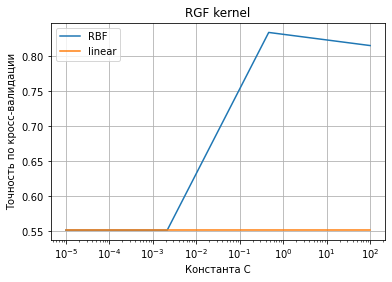

In [91]:
plt.plot(c_list, rbf_accuracy_list, label='RBF')
plt.plot(c_list, linear_accuracy_list, label='linear')
plt.xscale("log")
plt.title('RGF kernel')
plt.xlabel('Константа С')
plt.ylabel('Точность по кросс-валидации')
plt.legend()
plt.grid()
plt.show()

In [92]:
c_list = np.logspace(-5, 2, 4)
degrees = [d for d in range(2, 11, 2)]
poly_accuracy_dict = dict()

for d in degrees:
    poly_accuracy_dict[d] = []
    for c in c_list:
        model = SVC(kernel='poly', C=c, degree=d)
        poly_accuracy_dict[d].append(check_model(model, X_train, y_train).mean())
        print(model, poly_accuracy_dict[d][-1])
    print()

SVC(C=1e-05, degree=2, kernel='poly') 0.55125
SVC(C=0.0021544346900318843, degree=2, kernel='poly') 0.55125
SVC(C=0.4641588833612782, degree=2, kernel='poly') 0.8387500000000001
SVC(C=100.0, degree=2, kernel='poly') 0.865

SVC(C=1e-05, degree=4, kernel='poly') 0.55125
SVC(C=0.0021544346900318843, degree=4, kernel='poly') 0.55125
SVC(C=0.4641588833612782, degree=4, kernel='poly') 0.78125
SVC(C=100.0, degree=4, kernel='poly') 0.8400000000000001

SVC(C=1e-05, degree=6, kernel='poly') 0.55125
SVC(C=0.0021544346900318843, degree=6, kernel='poly') 0.5650000000000001
SVC(C=0.4641588833612782, degree=6, kernel='poly') 0.71875
SVC(C=100.0, degree=6, kernel='poly') 0.8162499999999999

SVC(C=1e-05, degree=8, kernel='poly') 0.55125
SVC(C=0.0021544346900318843, degree=8, kernel='poly') 0.58375
SVC(C=0.4641588833612782, degree=8, kernel='poly') 0.6975
SVC(C=100.0, degree=8, kernel='poly') 0.8

SVC(C=1e-05, degree=10, kernel='poly') 0.55125
SVC(C=0.0021544346900318843, degree=10, kernel='poly') 0.592

Давайте посмотрим на распределение классов в признаковых подпространствах:

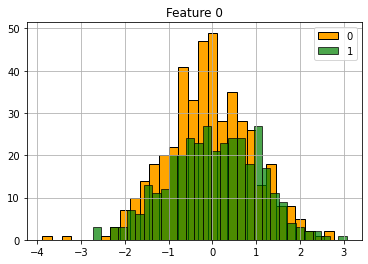

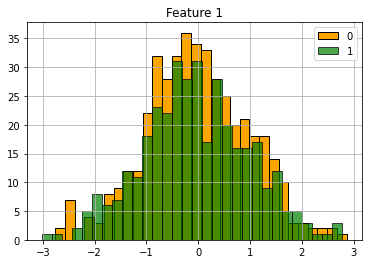

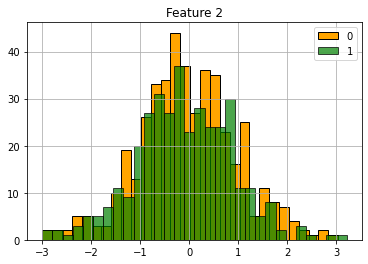

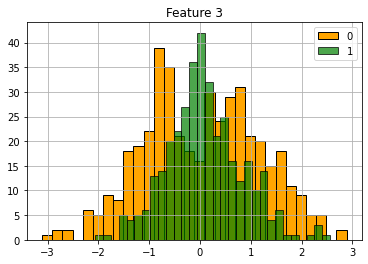

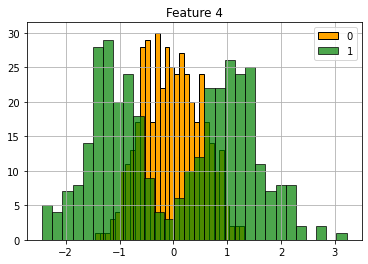

In [93]:
features = '01234'

X_cls_0 = X_cls = X_train[y_train.values == 0]
y_cls_0 = y_train[y_train.values == 0]
X_cls_1 = X_cls = X_train[y_train.values == 1]
y_cls_1 = y_train[y_train.values == 1]

for f in features:
    plt.hist(X_cls_0[f], color='orange', bins=30, 
             edgecolor='black', label='0', alpha=1)
    plt.hist(X_cls_1[f], color='green', bins=30, 
             edgecolor='black', label='1', alpha=0.7)
    plt.title('Feature ' + f)
    plt.grid()
    plt.legend()
    plt.show()

Исходя из распределения значений признаков для каждого класса, можем сделать вывод, что признаки 0, 1, 2 несут мало информации о классе объекта. Исключим их из обучения. <br>
Что касается признаков 3 и 4, то для каждого из них объекты одного класса сосредоточены на отрезке [-1, 1], а другого - вне этого отрезка. Если возвести оба признака в квадрат, разделить классы будет проще.

Подберем по кросс-валидации тип ядра и коэффициент регуляризации.

In [94]:
X_arr = X_train.to_numpy()
X_arr.shape

(800, 5)

In [95]:
X_3344 = np.concatenate([((1.5 * X_arr[:, 3]) ** 2).reshape((-1, 1)), ((1.5 * X_arr[:, 4]) ** 2).reshape((-1, 1))], axis=1)
X_3344.shape

(800, 2)

In [96]:
c_list = np.linspace(0.5, 15, 15)
rbf_accuracy_list = []

model_list = [SVC(kernel='rbf', C=c) for c in c_list]

for model in model_list:
    rbf_accuracy_list.append(check_model(model, X_3344, y_train, cv=5).mean())
    print(model, rbf_accuracy_list[-1])

SVC(C=0.5) 0.8875000000000002
SVC(C=1.5357142857142858) 0.89
SVC(C=2.5714285714285716) 0.89375
SVC(C=3.6071428571428577) 0.89
SVC(C=4.642857142857143) 0.8887499999999999
SVC(C=5.678571428571429) 0.89
SVC(C=6.714285714285715) 0.89125
SVC(C=7.750000000000001) 0.89125
SVC(C=8.785714285714286) 0.89125
SVC(C=9.821428571428573) 0.89125
SVC(C=10.857142857142858) 0.89125
SVC(C=11.892857142857144) 0.89125
SVC(C=12.92857142857143) 0.89125
SVC(C=13.964285714285715) 0.89125
SVC(C=15.0) 0.89125


In [103]:
c_list = np.logspace(-3, 2, 6)
linear_accuracy_list = []

model_list = [SVC(kernel='linear', C=c) for c in c_list]

for model in model_list:
    linear_accuracy_list.append(check_model(model, X_3344, y_train, cv=5).mean())
    print(model, linear_accuracy_list[-1])

SVC(C=0.001, kernel='linear') 0.7924999999999999
SVC(C=0.01, kernel='linear') 0.8637499999999999
SVC(C=0.1, kernel='linear') 0.885
SVC(kernel='linear') 0.88125
SVC(C=10.0, kernel='linear') 0.8799999999999999
SVC(C=100.0, kernel='linear') 0.8825


In [109]:
c_list = np.logspace(-2, 2, 9)
gamma_list = np.linspace(0.001, 2, 20)
rbf_accuracy_list = []

model_list = [SVC(kernel='rbf', C=c, gamma=gamma) for c in c_list for gamma in gamma_list]

for model in model_list:
    rbf_accuracy_list.append(check_model(model, X_3344, y_train, cv=5).mean())
    print(model, round(rbf_accuracy_list[-1], 3))

SVC(C=0.01, gamma=0.001) 0.551
SVC(C=0.01, gamma=0.22311111111111112) 0.704
SVC(C=0.01, gamma=0.44522222222222224) 0.655
SVC(C=0.01, gamma=0.6673333333333333) 0.571
SVC(C=0.01, gamma=0.8894444444444445) 0.551
SVC(C=0.01, gamma=1.1115555555555554) 0.551
SVC(C=0.01, gamma=1.3336666666666666) 0.551
SVC(C=0.01, gamma=1.5557777777777777) 0.551
SVC(C=0.01, gamma=1.7778888888888889) 0.551
SVC(C=0.01, gamma=2.0) 0.551
SVC(C=0.03162277660168379, gamma=0.001) 0.551
SVC(C=0.03162277660168379, gamma=0.22311111111111112) 0.852
SVC(C=0.03162277660168379, gamma=0.44522222222222224) 0.866
SVC(C=0.03162277660168379, gamma=0.6673333333333333) 0.868
SVC(C=0.03162277660168379, gamma=0.8894444444444445) 0.855
SVC(C=0.03162277660168379, gamma=1.1115555555555554) 0.847
SVC(C=0.03162277660168379, gamma=1.3336666666666666) 0.831
SVC(C=0.03162277660168379, gamma=1.5557777777777777) 0.812
SVC(C=0.03162277660168379, gamma=1.7778888888888889) 0.796
SVC(C=0.03162277660168379, gamma=2.0) 0.78
SVC(C=0.1, gamma=0.001)

ValueError: x and y must have same first dimension, but have shapes (9,) and (90,)

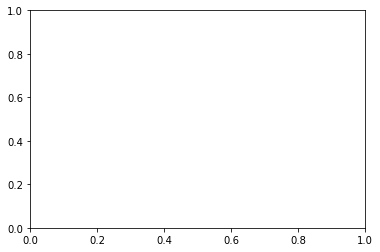

In [108]:
plt.plot(c_list, rbf_accuracy_list, label='RBF')
plt.plot(c_list, linear_accuracy_list, label='linear')
plt.xscale("log")
plt.title('RGF kernel')
plt.xlabel('Константа С')
plt.ylabel('Точность по кросс-валидации')
plt.legend()
plt.grid()
plt.show()

In [39]:
c_list = np.logspace(-5, 2, 7)
degrees = [d for d in range(2, 5, 1)]
poly_accuracy_dict = dict()

for d in degrees:
    poly_accuracy_dict[d] = []
    for c in c_list:
        model = SVC(kernel='poly', C=c, degree=d)
        poly_accuracy_dict[d].append(check_model(model, X_3344, y_train).mean())
        print(model, poly_accuracy_dict[d][-1])
    print()

SVC(C=1e-05, degree=2, kernel='poly') 0.55125
SVC(C=0.00014677992676220705, degree=2, kernel='poly') 0.555
SVC(C=0.0021544346900318843, degree=2, kernel='poly') 0.63125
SVC(C=0.03162277660168379, degree=2, kernel='poly') 0.76625
SVC(C=0.4641588833612782, degree=2, kernel='poly') 0.83125
SVC(C=6.812920690579622, degree=2, kernel='poly') 0.85875
SVC(C=100.0, degree=2, kernel='poly') 0.865

SVC(C=1e-05, kernel='poly') 0.5525
SVC(C=0.00014677992676220705, kernel='poly') 0.5937499999999999
SVC(C=0.0021544346900318843, kernel='poly') 0.64
SVC(C=0.03162277660168379, kernel='poly') 0.7375
SVC(C=0.4641588833612782, kernel='poly') 0.8025
SVC(C=6.812920690579622, kernel='poly') 0.8362499999999999
SVC(C=100.0, kernel='poly') 0.85625

SVC(C=1e-05, degree=4, kernel='poly') 0.56875
SVC(C=0.00014677992676220705, degree=4, kernel='poly') 0.6074999999999999
SVC(C=0.0021544346900318843, degree=4, kernel='poly') 0.65
SVC(C=0.03162277660168379, degree=4, kernel='poly') 0.73125
SVC(C=0.4641588833612782, deg

Распределение классов в новом признаковом пространстве:

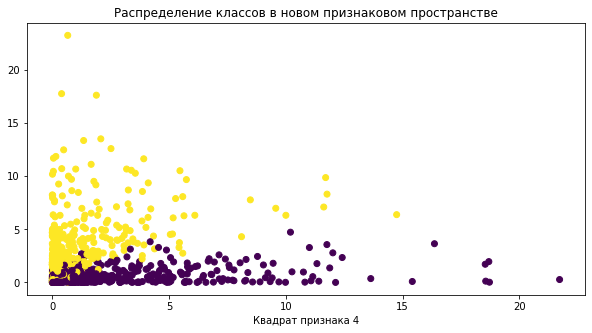

In [40]:
plt.figure(figsize=(10, 5))
plt.scatter(X_3344[:, 0], X_3344[:, 1], c=y_train.to_numpy())
plt.title('Распределение классов в новом признаковом пространстве')
plt.xlabel('Квадрат признака 3')
plt.xlabel('Квадрат признака 4')
plt.show()

В результате лучшей моделью оказалась модель с RBF-ядром:

In [41]:
best_model = SVC(C=2.5714285714285716)
print(cross_val_score(best_model, X_3344, y_train, cv=5, n_jobs=4, scoring='accuracy').mean())

0.89375


In [42]:
X_arr_test = X_test.to_numpy()
X_3344_test = np.concatenate([(X_arr_test[:, 3] ** 2).reshape((-1, 1)), (X_arr_test[:, 4] ** 2).reshape((-1, 1))], axis=1)
X_3344_test.shape

(10, 2)

Точность на тесте:

In [43]:
best_model = SVC(C=2.5714285714285716).fit(X_3344, y_train.to_numpy().reshape((-1, )))
y_pred = best_model.predict(X_3344_test)
print(accuracy_score(y_test.to_numpy().reshape((-1,)), y_pred.reshape((-1,))))

0.8


**Отправьте код обучения модели с оптимальными параметрами в проверяющую систему, воспользовавшись приложенным шаблоном (svm_solution.py) из проверяющей системы.**

Разбалловка задания следующая:

_На паблике:_ 

|accuracy | балл |
| ------------- | -----|
|> 0.8 | 5 |
|>= 0.6 | 1 |
|< 0.6 | 0 |


_На привате:_

|accuracy | балл |
| ------------- | -----|
|> 0.91 | 15 |
|>= 0.86 | 10 |
|>= 0.6 | 5 |
|< 0.6 | 0 |

# 4. Обучите лучшую SVM модель (4 балла)

Попробуйте обучить **логистическую регрессию** на этой выборке, и по кросс-валидации оцените влияние гиперпараметров на линейную модель.

In [76]:
from sklearn.linear_model import LogisticRegression

In [77]:
c_list = np.logspace(-5, 1, 7)
log_reg_accuracy_list = []
l1_log_reg_accuracy_list = []
l2_log_reg_accuracy_list = []

for c in c_list:
    logreg = LogisticRegression(penalty='none', solver='lbfgs', max_iter=300, tol=1e-5)
    l1_logreg = LogisticRegression(penalty='l1', C=c, solver='liblinear', max_iter=300, tol=1e-5)
    l2_logreg = LogisticRegression(penalty='l2', C=c, max_iter=200, tol=1e-5)
    
    log_reg_accuracy_list.append(cross_val_score(logreg, X_train, y_train.to_numpy().reshape((-1,)), 
                                                 cv=5, scoring='accuracy').mean())
    l1_log_reg_accuracy_list.append(cross_val_score(l1_logreg, X_train, y_train.to_numpy().reshape((-1,)), 
                                                    cv=5, scoring='accuracy').mean())
    l2_log_reg_accuracy_list.append(cross_val_score(l2_logreg, 
                                                    X_train, y_train.to_numpy().reshape((-1,)), 
                                                    cv=5, scoring='accuracy').mean())

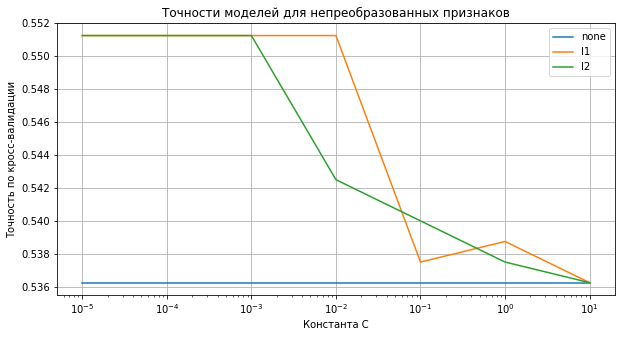

In [78]:
plt.figure(figsize=(10, 5))
plt.plot(c_list, log_reg_accuracy_list, label='none')
plt.plot(c_list, l1_log_reg_accuracy_list, label='l1')
plt.plot(c_list, l2_log_reg_accuracy_list, label='l2')
plt.xscale("log")
plt.title('Точности моделей для непреобразованных признаков')
plt.xlabel('Константа С')
plt.ylabel('Точность по кросс-валидации')
plt.legend()
plt.grid()
plt.show()

In [79]:
X_arr = X_train.to_numpy()
X_3344 = np.concatenate([(X_arr[:, 3] ** 2).reshape((-1, 1)), (X_arr[:, 4] ** 2).reshape((-1, 1))], axis=1)
X_0123344 = np.concatenate([X_arr[:, 0:3], X_3344], axis=1)
X_0123344.shape

(800, 5)

In [80]:
c_list = np.logspace(-5, 2, 7)
log_reg_accuracy_list = []
l1_log_reg_accuracy_list = []
l2_log_reg_accuracy_list = []

max_iter = 2000
tol = 1e-10

for c in c_list:
    logreg = LogisticRegression(penalty='none', solver='lbfgs', max_iter=max_iter, tol=tol)
    l1_logreg = LogisticRegression(penalty='l1', C=c, solver='liblinear', max_iter=max_iter, tol=tol)
    l2_logreg = LogisticRegression(penalty='l2', C=c, max_iter=max_iter, tol=tol)
    
    log_reg_accuracy_list.append(cross_val_score(logreg, X_0123344, y_train.to_numpy().reshape((-1,)), 
                                                 cv=5, scoring='accuracy').mean())
    l1_log_reg_accuracy_list.append(cross_val_score(l1_logreg, X_0123344, y_train.to_numpy().reshape((-1,)), 
                                                    cv=5, scoring='accuracy').mean())
    l2_log_reg_accuracy_list.append(cross_val_score(l2_logreg, X_0123344, y_train.to_numpy().reshape((-1,)), 
                                                    cv=5, scoring='accuracy').mean())

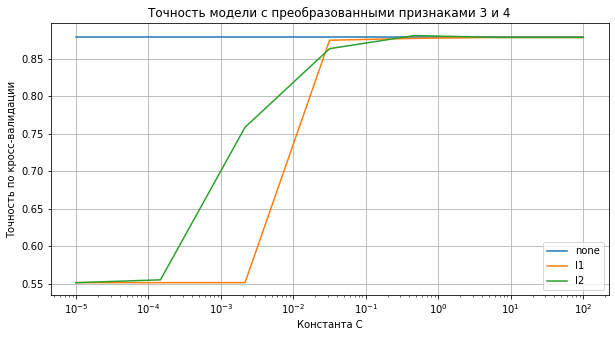

In [81]:
plt.figure(figsize=(10, 5))
plt.plot(c_list, log_reg_accuracy_list, label='none')
plt.plot(c_list, l1_log_reg_accuracy_list, label='l1')
plt.plot(c_list, l2_log_reg_accuracy_list, label='l2')
plt.xscale("log")
plt.title('Точность модели с преобразованными признаками 3 и 4')
plt.xlabel('Константа С')
plt.ylabel('Точность по кросс-валидации')
plt.legend()
plt.grid()
plt.show()

In [82]:
print(max(l2_log_reg_accuracy_list))

0.88125


In [83]:
X_arr = X_train.to_numpy()
X_3344 = np.concatenate([(X_arr[:, 3] ** 2).reshape((-1, 1)), (X_arr[:, 4] ** 2).reshape((-1, 1))], axis=1)
X_3344.shape

(800, 2)

In [52]:
c_list = np.logspace(-5, 2, 7)
log_reg_accuracy_list = []
l1_log_reg_accuracy_list = []
l2_log_reg_accuracy_list = []

max_iter = 2000
tol = 1e-10

for c in c_list:
    logreg = LogisticRegression(penalty='none', solver='lbfgs', max_iter=max_iter, tol=tol)
    l1_logreg = LogisticRegression(penalty='l1', C=c, solver='liblinear', max_iter=max_iter, tol=tol)
    l2_logreg = LogisticRegression(penalty='l2', C=c, max_iter=max_iter, tol=tol)
    
    log_reg_accuracy_list.append(cross_val_score(logreg, X_3344, y_train.to_numpy().reshape((-1,)), 
                                                 cv=5, scoring='accuracy').mean())
    l1_log_reg_accuracy_list.append(cross_val_score(l1_logreg, X_3344, y_train.to_numpy().reshape((-1,)), 
                                                    cv=5, scoring='accuracy').mean())
    l2_log_reg_accuracy_list.append(cross_val_score(l2_logreg, X_3344, y_train.to_numpy().reshape((-1,)), 
                                                    cv=5, scoring='accuracy').mean())

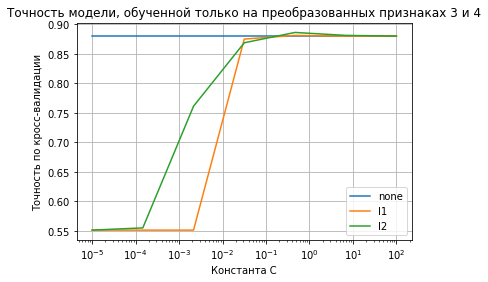

In [53]:
plt.plot(c_list, log_reg_accuracy_list, label='none')
plt.plot(c_list, l1_log_reg_accuracy_list, label='l1')
plt.plot(c_list, l2_log_reg_accuracy_list, label='l2')
plt.xscale("log")
plt.title('Точность модели, обученной только на преобразованных признаках 3 и 4')
plt.xlabel('Константа С')
plt.ylabel('Точность по кросс-валидации')
plt.legend()
plt.grid()
plt.show()

In [54]:
print(max(l2_log_reg_accuracy_list))
print(np.argmax(l2_log_reg_accuracy_list))

0.8862500000000001
4


In [55]:
c_list[4]

0.4641588833612782

Лучшей моделью логистической регрессии среди обученных оказалсь модель с L2 регуляризацией и параметром регуляризации $С = 0.464$. Она показала точность 0.88625, что слегка хуже, чем лучший SVM классификатор.

Сделайте выводы о влиянии выбора гиперпараметров на качество обучения линейной и SVC моделей. Также опишите, какие преобразования выборки/подбор каких гиперпараметров помогли добиться высокого качества на кросс-валидации в данной задаче.

**Вывод:** <br> <br>
SVM: <br>
1) Исходная выборка была линейно не разделимой, поэтому SVM с линейным ядром при любой константе регуляризации выдавал точность чуть выше 0.55. После преобразования признаков (удаления 0, 1, 2 признаков, т.к. их распределение в каждом классе не отличается, и возведения в квадрат признаков 3 и 4 по выше описанным причинам) выборка стала близкой к линейно разделимой (это можно увидеть  на графике распределения классов в новом признаковом простарнстве), и SVM с линейным ядром показал точность, близкую к лучшей модели. <br>
2) SVM c RBF ядром на исходных данных при умеренной регуляризации показал приемлемую точность 0.84 (при слишком сильной регуляризации не отлчиался от SVM с линейным ядром), а после преобразования признакового пространства оказался лучшей моделью с точностью 0.89375. Также можно сказать, что слишком сильная и слабая регуляризации приводили к меньшей точности, что говорит о недообучении в первом случае и переобучении во втором. <br>

<br>
 
Логистическая регрессия: <br>
1) при обучении логистической регрессии на непреобразованных данных можно видеть важность параметра С (обратного коэффициенту регуляризации). При малых значениях С веса модели сильно штрафуются, вследствие чего "шумовые" (не несущие информацию о классе) признаки 0, 1, 2  оказывают мало влияния. При увеличении С качество модели падает до уровня логистической регрессии без регуляризации. В любом случае, получившиеся модели сложно назвать удовлетворительными. <br>
2) при обучении на преобразованных данных (убрали шумовые признаки 0, 1, 2, а также возвели в квадрат признаки 3, 4) получили хорошее качество моделей при слабой регуляризации (больших С). Поскольку осталось всего два признака, слишком сильная регуляризация будет ухудшать качество модели.  

# 5. Ограничения SVM (3 балла)

В предыдущих заданиях мы убедились в мощности и гибкости моделей SVM. Теперь ответим на вопрос, насколько реально обучить модель SVM на выборках большого размера или с большим числом признаков. 
    
   Нужно провести два эксперимента. В первом перебирать размер выборки
    и для каждого запуска посчитать реальное время обучения модели. При этом
    делить выборку на обучение и тестирование не нужно. Также качество обученной модели в данном эксперименте не имеет значение. Размеры выборки предлагается перебирать в диапазоне range(1000, 10001, 1000) с использованием generate_data_with_balanced_classes(size=n). 
    
   Необходимо сравнить время обучения SVM с логистической регрессией. Для этого
    замеры повторите также для модели sklearn.linear_model.LogisticRegression. Время обучения одной модели замеряйте 
    с помощью стандартной библиотеки time (пример в ячейке ниже). 
    
Вы можете поставить эксперименты и с большими выборками, чем предлагается в задании (сгенерировать их),  
тогда эффект должен быть виден еще сильнее.

In [56]:
# Как замерять время
import time
time_start = time.time()
time.sleep(1) # Вместо этой команды - запуск замеряемого алгоритма
print("Время работы:", time.time() - time_start)

Время работы: 1.0047907829284668


In [57]:
def generate_data_with_balanced_classes(size=500, d=2, noise_scale=0.1):
    X = np.random.normal(size=(size*2, d))
    mask = X[:, 1] ** 2 > X[:, 0] - 0.1 + np.random.normal(scale=noise_scale)
    y = np.ones(len(X))
    y[mask] = 0
    return X, y

In [58]:
size_list = [n for n in range(1000, 10001, 1000)]
svm_time_list = []
logreg_time_list = []

for n in size_list:
    X, y = generate_data_with_balanced_classes(size=n)
    logreg = LogisticRegression()
    logreg_start = time.time()
    logreg.fit(X, y)
    logreg_time_list.append(time.time() - logreg_start)
    
    svm = SVC()
    svm_start = time.time()
    svm.fit(X, y)
    svm_time_list.append(time.time() - svm_start)    

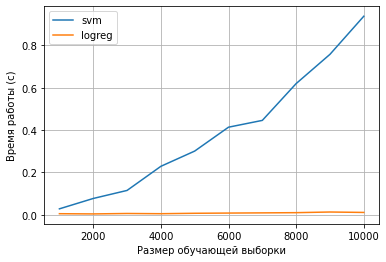

In [59]:
plt.plot(size_list, svm_time_list, label='svm')
plt.plot(size_list, logreg_time_list, label='logreg')
plt.title('')
plt.xlabel('Размер обучающей выборки')
plt.ylabel('Время работы (с)')
plt.legend()
plt.grid()
plt.show()

Во втором эксперименте предлагается проделать то же самое, что и в первом эксперименте, только меняя размерность пространства признаков. 
    Для этого можете воспользоваться функцией generate_data_with_balanced_classes(dim=d). Признаки предлагается перебирать по сетке $range(10, 1001, 100)$. 

In [60]:
size_list = [n for n in range(10, 1001, 10)]
svm_time_list = []
logreg_time_list = []

for d in size_list:
    X, y = generate_data_with_balanced_classes(d=d)
    logreg = LogisticRegression()
    logreg_start = time.time()
    logreg.fit(X, y)
    logreg_time_list.append(time.time() - logreg_start)
    
    svm = SVC()
    svm_start = time.time()
    svm.fit(X, y)
    svm_time_list.append(time.time() - svm_start)    

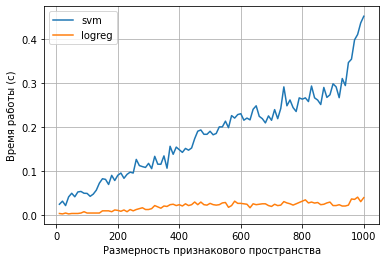

In [61]:
plt.plot(size_list, svm_time_list, label='svm')
plt.plot(size_list, logreg_time_list, label='logreg')
plt.title('')
plt.xlabel('Размерность признакового пространства')
plt.ylabel('Время работы (с)')
plt.legend()
plt.grid()
plt.show()

Постройте графики времени работы в зависимости от числа объектов для SVM и логистической регрессии, сравните их и сделайте выводы.
    
Придумывая обоснование получившимся результатам попробуйте использовать
    вид решаемой задачи в SVM, который был дан вам на лекции. 

**Вывод:** <br>
В обоих случаях получили, что логистическая регрессия оказывается значительно более быстрой, чем SVM. <br>
Это можно объяснить тем фактом, что в двойственной задаче для SVM классификации в функционале присутствует двойная сумма по всем объектам обучающей выборки, а под суммой вычисляется ядро (сложность вычисления ядра - О(d), где d - размерность признакового пространства, а ядро вычисляетя для всех пар объектов, т.е. квадратичная сложность от размера выборки).

# 6. Уменьшение размерности входа (4 балла)

Если уменьшение числа объектов сложная и зачастую невозможная задача, то
    для понижения числа признаков существует стандартное решение. В предыдущих заданиях Вы уже сталкивались с l1-регуляризацией, которая позволяла уменьшить число признаков в задаче линейной классификации/регрессии. Однако для большинства ML-алгоритмов такой способ уменьшения числа признаков неприменим.
    
   Зато существует стандартное для всех алгоритмов понижение размерности входа. Данный алгоритм называется Principal Component Analysis (PCA, метод главных компонент). Он находит подпространство требуемой размерности $k$ ($k << d$, где d изначальная размерность входа), максимально сохраняющую дисперсию выборки, или, что то же самое, - сумма квадратов длин проекций объектов на которое будет минимальна. Подробнее об этом можете почитать тут https://scikit-learn.org/stable/modules/decomposition.html#pca. 
    
   **Эксперимент:** Проекция в очень малое число координат сильно "упрощает" выборку, из-за чего качество решения задачи может в итоге упасть. **В следующем эксперименте предлагается исследовать зависимость скорости работы метода и качества решения задачи при использовании понижения размерности. Требуется построить два графика:**

1. График зависимости времени работы всего цикла обучения от числа признаков $k$, которое остается после применения PCA. 
2. График зависимости качества решения (accuracy) задачи классификации от числа признаков $k$, которое остается после применения PCA.
    
При этом под полным циклом обучения подразумевается обучение PCA + обучение SVM. Данные для обучения: первые две координаты - луны, которые были в первом задании, а остальные координаты, случайные. 
Таким образом, без понижения размерности SVM с rbf ядром должен иметь точность близкую к 100\%. Чтобы лучше
видеть эффект на графиках, можете менять размер генерируемой выборки. Для данных размеров $k$ рекомендуется перебирать от 10 до 500 (тогда будет видна требуемая закономерность). 
    
   **P.S. Не забывайте делить выборку на обучение и валидацию в этом эксперименте** (так как мы смотрим на качество, мы хотим считать его честно). При этом PCA как и любой другой алгоритм ML тоже нельзя учить на тесте. Общая схема применения PCA описана в ячейках ниже. 

In [62]:
X_moons, y_moons = make_moons_cls(2000, 1000)

In [63]:
X_moons.shape

(2000, 1000)

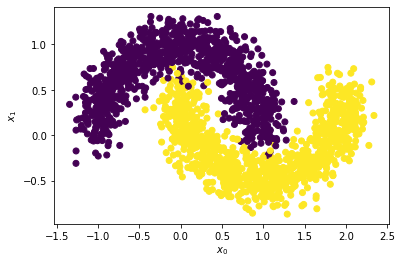

In [64]:
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons)
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.show()

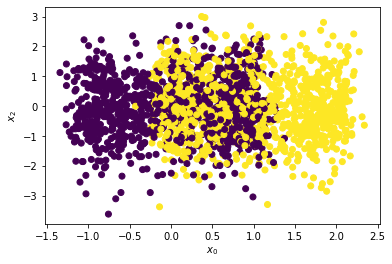

In [65]:
plt.scatter(X_moons[:, 0], X_moons[:, 2], c=y_moons)
plt.xlabel('$x_0$')
plt.ylabel('$x_2$')
plt.show()

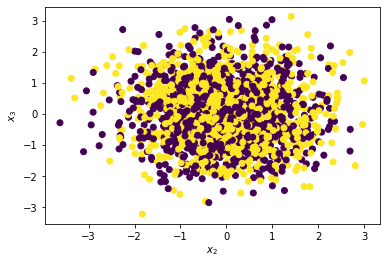

In [66]:
plt.scatter(X_moons[:, 2], X_moons[:, 3], c=y_moons)
plt.xlabel('$x_2$')
plt.ylabel('$x_3$')
plt.show()

Казалось бы понизить размерность в этой задаче достаточно легко, нужно просто выбрать только первые две координаты. Однако из-за нелинейности разделяющей поверхности, для PCA это задача нетривиальна. Такая же ситуация наблюдается и в большинстве прикладных задач. Теперь переходите **к эксперименту** :)

In [67]:
# Пример правильного обучения PCA с делением на train/test
pca_model = PCA(n_components=500)

X_moons_train, X_moons_test, y_moons_train, y_moons_test = train_test_split(
    X_moons, y_moons, test_size=0.2) # делим выборку на трейн тест для оценки качества всего алгоритма

X_train_for_pca, X_train_for_svc, y_train_for_pca, y_train_for_svc = train_test_split(
    X_moons_train, y_moons_train, test_size=0.5) # делим выборку на трейн тест для оценки качества всего алгоритма

print(X_moons.shape, y_moons.shape)
print(X_moons_train.shape, y_moons_train.shape)
print(X_train_for_pca.shape, y_train_for_pca.shape)

# Учим PCA
pca_model.fit(X_train_for_pca)

# Применяем PCA
X_moons_test_transformed = pca_model.transform(X_moons_test)
X_train_for_svc_transformed = pca_model.transform(X_train_for_svc)

print(X_train_for_svc_transformed.shape)

# Учим SVC (на другой выборке чтобы не переобучиться)
svc_on_transformed = SVC(kernel='rbf')
svc_on_transformed.fit(X_train_for_svc_transformed, y_train_for_svc)

preds = svc_on_transformed.predict(X_moons_test_transformed)

print('Accuracy after PCA:', accuracy_score(preds, y_moons_test))

(2000, 1000) (2000,)
(1600, 1000) (1600,)
(800, 1000) (800,)
(800, 500)
Accuracy after PCA: 0.5925


In [68]:
dims = np.arange(10, 501, 10)
accuracy_list = []
time_list = []
pca_time_list = []
svm_time_list = []

random_state = 15

for d in dims:
    pca_model = PCA(n_components=500)
    
    # делим выборку на трейн тест для оценки качества всего алгоритма
    X_moons_train, X_moons_test, y_moons_train, y_moons_test = train_test_split(
        X_moons, y_moons, test_size=0.2, random_state=random_state) 

    # делим выборку на трейн тест для оценки качества всего алгоритма
    X_train_for_pca, X_train_for_svc, y_train_for_pca, y_train_for_svc = train_test_split(
        X_moons_train, y_moons_train, test_size=0.5, random_state=random_state)

    # Учим PCA
    start = time.time()
    pca_model.fit(X_train_for_pca)
    pca_time = time.time() - start

    # Применяем PCA
    X_moons_test_transformed = pca_model.transform(X_moons_test)
    X_train_for_svc_transformed = pca_model.transform(X_train_for_svc)

    svc_on_transformed = SVC(kernel='rbf')
    
    # Учим SVC (на другой выборке чтобы не переобучиться)
    start = time.time()
    svc_on_transformed.fit(X_train_for_svc_transformed, y_train_for_svc)
    svc_time = time.time() - start

    preds = svc_on_transformed.predict(X_moons_test_transformed)

    time_list.append(svc_time + pca_time)
    pca_time_list.append(pca_time)
    svm_time_list.append(svc_time)
    accuracy_list.append(accuracy_score(preds, y_moons_test))
    

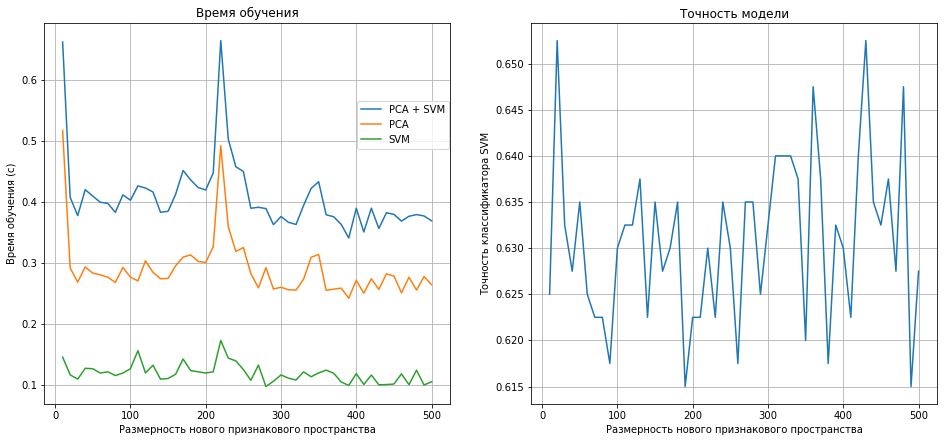

In [69]:
fig, axs = plt.subplots(figsize=(16, 7), ncols=2)

axs[0].plot(dims, time_list, label='PCA + SVM')
axs[0].plot(dims, pca_time_list, label='PCA')
axs[0].plot(dims, svm_time_list, label='SVM')
axs[0].set_title('Время обучения')
axs[0].set_xlabel('Размерность нового признакового пространства')
axs[0].set_ylabel('Время обучения (с)')
axs[0].legend(loc=(0.77, 0.67))
axs[0].grid()

axs[1].plot(dims, accuracy_list)
axs[1].set_title('Точность модели')
axs[1].set_xlabel('Размерность нового признакового пространства')
axs[1].set_ylabel('Точность классификатора SVM')
axs[1].grid()

plt.show()

Опишите в выводе как ведет себя качество решения задачи и время работы в зависимости от числа компонент в PCA.  

**Вывод:** по графикам можно сделать вывод, что зависимости как таковой между суммарным временем обучения/качеством решения и числом компонент нет, в среднем суммарное время обучения чуть меньше 1.2, а точность решения - от 0.57 до 0.62. В то же время, можно заметить, что в среднем вклад PCA во время работы в два раза больше, чем SVM.

# 7. Калибровка вероятностей (3 балла)

Иногда в задаче классификации важно знать уверенность отнесения к тому или иному классу. В SVM за это отвечает параметр отступа model.decision_function(X). Однако по нему сложно утверждать с какой вероятностью объект относится к тому или иному классу.

Чтобы это понять давайте визуализируем, как соотносится сортировка объектов по отступам с сортировкой
по таргету (классу). То есь построим кривую, в которой по оси X - доля выборки с отступом, меньшим чем данный,
по оси Y - доля объектов класса 1 с отступом, меньшим чем данный среди всех объектов класса 1.   

In [70]:
from sklearn.datasets import make_classification
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

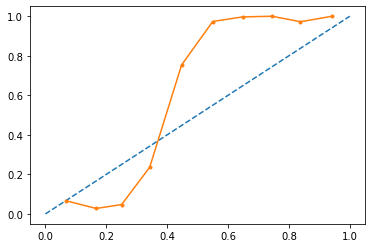

In [71]:
# generate 2 class dataset
X, y = make_classification(n_samples=5000, n_classes=2, weights=[1,1], random_state=1)

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)

# fit a model
model = SVC()
model.fit(trainX, trainy)

# predict probabilities
probs = model.decision_function(testX)

# reliability diagram
fop, mpv = calibration_curve(testy, probs, n_bins=10, normalize=True)

# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')

# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.show()

Вот мы и увидели проблему, линия отступов не ложится на пунктирную линию, что означает что оступы не соотвествуют реальным вероятностям отнесения к тому или иному классу.  

   Для этого существует такая процедура как калибровка вероятностей, при которой отступ для каждого объекта преобразовывается таким образом, чтобы соответствовать вероятности класса. После такого преобразования, полученное число становится интерпретируемой мерой уверенности модели. 

В данном задании Вам прелагается обучить логистическую регрессию на отступах модели, которая по оступу предсказывала бы класс. Именно вероятности этой калибровочной модели и будут нашими верными оценками вероятности класса для объекта:

$p(y_i | x_i) = p(y_i | margin_i)$

Для этого Вам потребуется написать несложный класс CalibratingLogisticRegression. И проверить что новые предсказания дают правильную калибровочную кривую

In [72]:
class CalibratingLogisticRegression:
    model = None
    
    def fit(self, x, y):
        assert len(x.shape) == 1 or x.shape[1] == 1
        self.model = LogisticRegression().fit(x.reshape((-1, 1)), y)
        
    def predict_proba(self, x):
        assert len(x.shape) == 1 or x.shape[1] == 1
        return self.model.predict_proba(x.reshape((-1, 1)))[:, 1]

Калибровочную модель и исходную модель нельзя учить на одних и тех же данных, чтобы избежать переобучения. (распределение отступов на обучении и тестовой выборке, скорее всего очень сильно отличается)

In [73]:
model = SVC()
N = len(trainX) // 2
model.fit(trainX[:N], trainy[:N])

SVC()

(1250,)


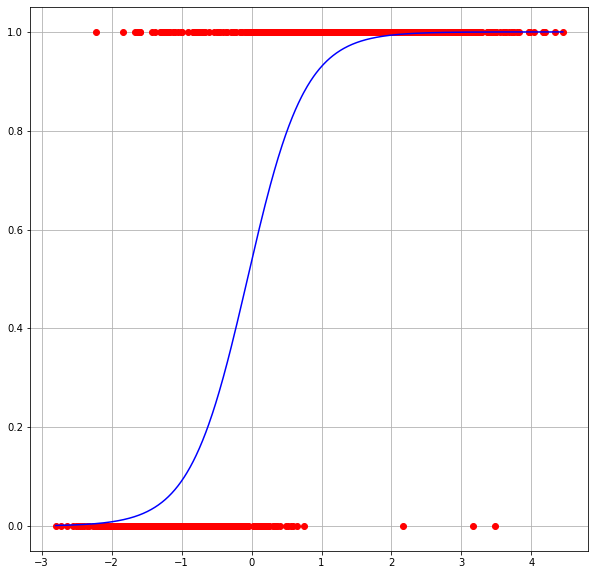

In [74]:
X_features_for_calibrating_model = model.decision_function(trainX[N:])
margin = X_features_for_calibrating_model.reshape((-1, 1))

# Учим калибровочную модель на второй половине данных
calibrating_model = CalibratingLogisticRegression()
calibrating_model.fit(X_features_for_calibrating_model, trainy[N:])
prob = calibrating_model.predict_proba(margin)

print(prob.shape)

# Как это выглядит на обучении
margin_sorted, probs_sorted_by_margin = zip(*sorted(zip(margin, prob)))
plt.figure(figsize=(10, 10))
plt.plot(margin, trainy[N:], 'ro')
plt.plot(margin_sorted, probs_sorted_by_margin, 'b')
plt.grid()
plt.show()

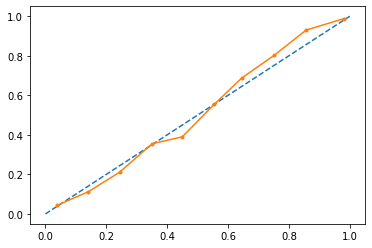

In [75]:
probs = calibrating_model.predict_proba(model.decision_function(testX))

# reliability diagram
fop, mpv = calibration_curve(testy, probs, n_bins=10, normalize=True)

# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')

# plot calibrated reliability
plt.plot(mpv, fop, marker='.')
plt.show()

Сделайте выводы о полученной модели. В каких задачах калибровка вероятностей могла бы быть полезной?

**Выводы:** калибровочная кривая полученной модели хорошо приближает пунктирную линию, то есть теперь SVM классификатор, основываясь на распределении отступов обучающей выборки, может предсказывать для нового объекта вероятность отнесения к тому или другому классу. <br>
Калибровка вероятности может быть полезна в задачах, где важно понимать степень уверенности алгоритма в прогнозе. Например, в задаче банковского скоринга часто применяют логистическую регрессию, поскольку она хорошо предсказывает вероятности. 

# Бонусное задание (2 балла)

Найдите мем про SVM лучше чем этот:

![texte](https://clck.ru/YyDTf)

Вставьте его внешней ссылкой и проверьте, что в сгенерированном html он отображается


![texte](https://www.meme-arsenal.com/memes/ebdd9923727df0357a57f3fa22e453eb.jpg)

**Перед тем, как сдать ноутбук на кросс-рецензирование, мы рекомендуем перезапустить ядро и выполнить весь ноутбук (cell -> run all). При правильном выполнении весь процесс работы ноутбука не должен занять больше 20 минут**